# DESI mini end-to-end test

Test end-to-end dataflow using a small number of tiles

In [1]:
import os, sys, glob
import numpy as np
import healpy as hp
from astropy.table import Table
import fitsio
import desimodel.io
import desimodel.footprint
import subprocess
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Set some environment variables and create output directories

Create directories under `$SCRATCH/desi/dev/end2end/`.

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | \$DESISURVEY_OUTPUT                               |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | \$DESI_SPECTRO_REDUX/\$SPECPROD                   |
| spectro/sim/mini/     | simdatadir    | \$DESI_SPECTRO_DATA = \$DESI_SPECTRO_SIM/$PIXPROD |


In [7]:
basedir = os.getenv('SCRATCH')+'/desi/dev/end2end'
surveydir = os.environ['DESISURVEY_OUTPUT'] = basedir+'/survey'
targetdir = basedir+'/targets'
fibassigndir = basedir+'/fiberassign'

os.environ['DESI_SPECTRO_REDUX'] = basedir+'/spectro/redux'
os.environ['DESI_SPECTRO_SIM'] = basedir+'/spectro/sim'
os.environ['PIXPROD'] = 'mini'
os.environ['SPECPROD'] = 'mini'

reduxdir = os.path.join(os.getenv('DESI_SPECTRO_REDUX'), os.getenv('SPECPROD'))
simdatadir = os.path.join(os.getenv('DESI_SPECTRO_SIM'), os.getenv('PIXPROD'))
os.environ['DESI_SPECTRO_DATA'] = simdatadir

os.makedirs(surveydir, exist_ok=True)
os.makedirs(targetdir, exist_ok=True)
os.makedirs(fibassigndir, exist_ok=True)
os.makedirs(reduxdir, exist_ok=True)
os.makedirs(simdatadir, exist_ok=True)

print('surveydir   ', surveydir)
print('targetdir   ', targetdir)
print('fibassigndir', fibassigndir)
print('reduxdir    ', reduxdir)
print('simdatadir  ', simdatadir)

surveydir    /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey
targetdir    /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets
fibassigndir /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign
reduxdir     /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini
simdatadir   /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/sim/mini


## Run survey simulations on a subset of tiles

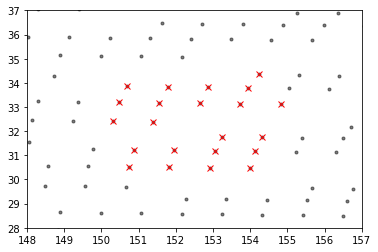

In [8]:
#- Make a subset of tiles to use
tiles = Table(desimodel.io.load_tiles())
ii = (150 < tiles['RA']) & (tiles['RA']<155) & (30<tiles['DEC']) & (tiles['DEC']<35)
clf()
plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.5)
plot(tiles['RA'][ii], tiles['DEC'][ii], 'rx')
xlim(148, 157); ylim(28, 37)
tiles_subset = tiles[ii]
tiles[ii].write('tiles-subset.fits', overwrite=True)

In [9]:
!time surveyinit --config-file ./desisurvey-config.yaml


real	0m19.711s
user	0m10.724s
sys	0m0.863s


In [10]:
#- Use 0d fiber assignment delay to move on with mini sim quickly
!time surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --create --fa-delay 0d


real	0m34.828s
user	0m1.957s
sys	0m0.905s


In [11]:
!ls $surveydir

ephem_2020-03-15_2020-04-15.fits  plan_2020-03-15.fits	surveyinit.fits
plan.fits			  scheduler.fits


In [12]:
!time surveysim --config-file ./desisurvey-config.yaml --seed 123 >> $surveydir/survey.log


real	0m26.683s
user	0m21.137s
sys	0m0.626s


In [13]:
import subprocess
import time
plan_cmd = 'surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --fa-delay 0d'
sim_cmd = 'surveysim --resume --config-file ./desisurvey-config.yaml --seed 123'
while True:
    lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
    progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
    ndone = np.count_nonzero(progress['status'] == 2)
    print('Starting {} with {}/{} tiles completed {}'.format(lastdate, ndone, len(progress), time.asctime()))
    if subprocess.call(plan_cmd.split()) != 0:
        break
    if subprocess.call(sim_cmd.split()) != 0:
        break

print('done observing all tiles')

Starting 2020-03-16 with 7/22 tiles completed Tue Sep 26 16:26:59 2017
Starting 2020-03-17 with 11/22 tiles completed Tue Sep 26 16:27:07 2017
Starting 2020-03-18 with 11/22 tiles completed Tue Sep 26 16:27:13 2017
Starting 2020-03-19 with 15/22 tiles completed Tue Sep 26 16:27:48 2017
Starting 2020-03-20 with 19/22 tiles completed Tue Sep 26 16:27:55 2017
Starting 2020-03-21 with 20/22 tiles completed Tue Sep 26 16:28:32 2017
Starting 2020-03-22 with 21/22 tiles completed Tue Sep 26 16:29:12 2017
Starting 2020-03-23 with 22/22 tiles completed Tue Sep 26 16:29:18 2017
done observing all tiles


In [15]:
!ls $surveydir

ephem_2020-03-15_2020-04-15.fits  plan_2020-03-21.fits
last_date.txt			  plan_2020-03-22.fits
plan.fits			  progress.fits
plan_2020-03-15.fits		  progress_2020-03-16_bookmark.fits
plan_2020-03-16.fits		  progress_2020-03-17_bookmark.fits
plan_2020-03-16_bookmark.fits	  progress_2020-03-19_bookmark.fits
plan_2020-03-17.fits		  progress_2020-03-20_bookmark.fits
plan_2020-03-17_bookmark.fits	  scheduler.fits
plan_2020-03-18.fits		  stats.fits
plan_2020-03-19.fits		  survey.log
plan_2020-03-19_bookmark.fits	  surveyinit.fits
plan_2020-03-20.fits		  weather_123.fits
plan_2020-03-20_bookmark.fits


### Convert progress.fits -> exposures.fits
progress.fits is one row per tile; convert that into a file with one row per exposure.

In [16]:
from desisurvey.progress import Progress
p = Progress(restore='progress.fits')
explist = p.get_exposures()
explist.write(os.path.join(surveydir, 'exposures.fits'), overwrite=True)

INFO:progress.py:133:__init__: Loaded progress from /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/progress.fits.


In [17]:
# Sanity check
assert np.all(np.in1d(tiles_subset['TILEID'], explist['tileid']))

## Study pixels

In [18]:
isbright = explist['pass'] > 4
isgray = explist['pass'] == 4
isdark = explist['pass'] < 4
istwilight = isbright & (explist['moonalt'] < 0)

(28, 37)

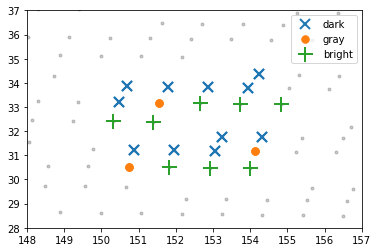

In [19]:
plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.2, label='_none_')
plot(explist['ra'][isdark], explist['dec'][isdark], 'x', ms=10, mew=2, label='dark')
plot(explist['ra'][isgray], explist['dec'][isgray], '.', ms=15, label='gray')
plot(explist['ra'][isbright], explist['dec'][isbright], '+', ms=15, mew=2, label='bright')
legend(loc='upper right')
xlim(148, 157); ylim(28, 37)

In [20]:
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, tiles_subset)
nexp = np.count_nonzero(np.in1d(explist['tileid'], tiles_subset['TILEID']) & ~istwilight)
print('{} tiles covered by {} exposures and {} healpixels'.format(len(tiles_subset), nexp, len(pixels)))

22 tiles covered by 28 exposures and 71 healpixels


In [21]:
pixels

array([5261, 5262, 5263, 5265, 5266, 5267, 5268, 5270, 5271, 5272, 5273,
       5274, 5275, 5276, 5277, 5278, 5279, 5281, 5283, 5284, 5285, 5286,
       5287, 5289, 5292, 5293, 5294, 5295, 5296, 5297, 5298, 5299, 5300,
       5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 5311,
       5314, 5320, 5321, 5322, 5323, 5324, 5326, 5344, 5345, 5346, 5347,
       5348, 5350, 5352, 5353, 5354, 5355, 5356, 5636, 5637, 5648, 5649,
       5650, 5651, 5652, 5653, 5654])

(28, 37)

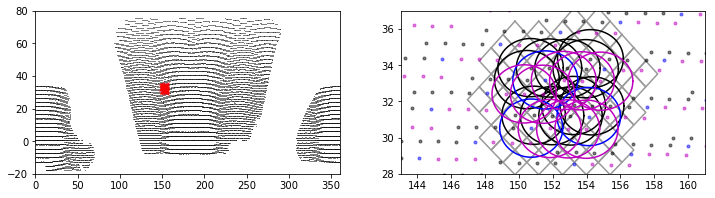

In [22]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plot(x,y, '-', color=color)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plot(ra, dec, '-', color='0.6')

xtiles = tiles_subset
figure(figsize=(12,3))
subplot(121)
plot(tiles['RA'], tiles['DEC'], 'k,', alpha=0.5)
plot(explist['ra'], explist['dec'], 'b.', alpha=0.5)
plot(xtiles['RA'], xtiles['DEC'], 'rx')
xlim(0,360); ylim(-20, 80)

subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='k', GRAY='b', BRIGHT='m')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = xtiles['PROGRAM'] == program
    for t in xtiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

xlim(143, 161); ylim(28, 37)

## Run select_mock_targets

In [23]:
#- Write subset of tiles table to file for input to mpi_select_mock_targets
tilefile = targetdir+'/test-tiles.fits'
Table(xtiles).write(tilefile, overwrite=True)
Table(xtiles)

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
1148,154.23,34.35,0,1,0.0148942,1.02536,1397.33,1.12968,DARK,1
1149,153.23,31.77,0,1,0.0207369,1.0252,1372.21,1.17033,DARK,1
1165,150.69,33.86,0,1,0.0126537,1.02517,1416.73,1.11412,DARK,1
6911,154.32,31.75,1,1,0.0229261,1.02521,1401.19,1.18603,DARK,1
6927,151.78,33.84,1,1,0.0134791,1.02517,1402.3,1.11972,DARK,1
11108,150.87,31.23,1,1,0.0189035,1.02543,1451.67,1.15767,DARK,1
12689,152.87,33.82,2,1,0.0149298,1.02516,1390.24,1.12964,DARK,1
16870,151.96,31.21,2,1,0.0207586,1.02544,1403.42,1.17082,DARK,1
18451,153.95,33.8,3,1,0.0170573,1.02516,1406.78,1.14435,DARK,1


In [24]:
os.environ['MPICH_GNI_FORK_MODE'] = 'FULLCOPY'
os.environ['KMP_AFFINITY'] = 'disabled'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['DESI_LOGLEVEL'] = 'INFO'
cmd = "srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00"
cmd += " mpi_select_mock_targets --output_dir {targetdir} --config select-mock-targets.yaml"
cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile}"
cmd = cmd.format(targetdir=targetdir, tilefile=tilefile)
print(cmd)

srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00 mpi_select_mock_targets --output_dir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --config select-mock-targets.yaml --seed 1 --nproc 16 --nside 64 --tiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/test-tiles.fits


In [25]:
#- Actually run that command, which will submit a batch job and wait for it to run
!$cmd

srun: job 7064124 queued and waiting for resources
srun: job 7064124 has been allocated resources
INFO:mpi_select_mock_targets:81:<module>: 22 tiles
INFO:mpi_select_mock_targets:92:<module>: 71/71 pixels remaining to do
INFO:mpi_select_mock_targets:133:<module>: rank 4 processes 2 pixels [5272 5273]
INFO:mpi_select_mock_targets:133:<module>: rank 8 processes 3 pixels [5283 5284 5285]
INFO:mpi_select_mock_targets:133:<module>: rank 3 processes 2 pixels [5270 5271]
INFO:mpi_select_mock_targets:133:<module>: rank 2 processes 3 pixels [5266 5267 5268]
INFO:mpi_select_mock_targets:133:<module>: rank 9 processes 2 pixels [5286 5287]
INFO:mpi_select_mock_targets:133:<module>: rank 5 processes 3 pixels [5274 5275 5276]
INFO:mpi_select_mock_targets:133:<module>: rank 15 processes 2 pixels [5303 5304]
INFO:mpi_select_mock_targets:133:<module>: rank 16 processes 3 pixels [5305 5306 5307]
INFO:mpi_select_mock_targets:133:<module>: rank 14 processes 2 pixels [5301 5302]
INFO:mpi_select_mock_targets

## Merge sky and standards

In [26]:
# cmd = "srun -N 4 -n 8 -c 16 -p debug -C haswell -t 00:05:00"
cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
print(cmd)
!$cmd

join_mock_targets --mockdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --force
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-dark.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-bright.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/targets.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/truth.fits
INFO:build.py:1068:join_targets_truth: Generating merged target list /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.0825502872467041
DEBUG: calc_priority has 344877 unobserved targets
4 of 344877 targets have priority

### Do some sanity checks on the results

In [27]:
targets = fitsio.read(targetdir+'/targets.fits')
truth   = fitsio.read(targetdir+'/truth.fits')
mtl     = fitsio.read(targetdir+'/mtl.fits')
std     = fitsio.read(targetdir+'/standards-dark.fits')
sky     = fitsio.read(targetdir+'/sky.fits')

In [28]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


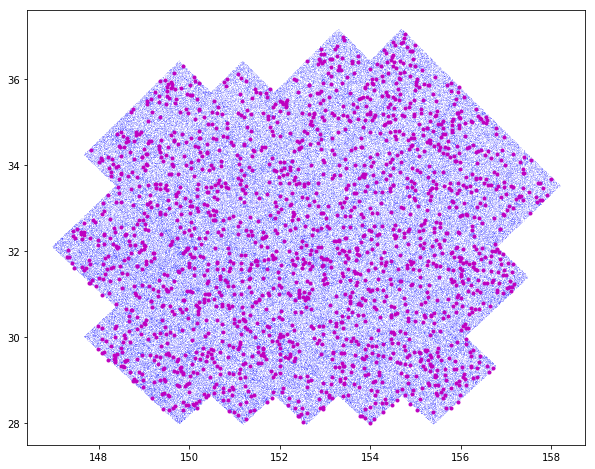

In [29]:
figure(figsize=(10,8))
plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plot(std['RA'], std['DEC'], 'm.')

## Run fiberassign

First, generate fiberassign configuration files pointing to the right inputs/outputs

In [30]:
#- Write list of tiles to consider
dx = open(fibassigndir+'/dark-tiles.txt', 'w')
bx = open(fibassigndir+'/bright-tiles.txt', 'w')
for tileid, program  in zip(xtiles['TILEID'], xtiles['PROGRAM']):
    if program == 'BRIGHT':
        bx.write(str(tileid)+'\n')
    else:
        dx.write(str(tileid)+'\n')

dx.close()
bx.close()

#- Generate config files for dark and bright
cmd = "config-fiberassign "
cmd += " --mtl {}/mtl.fits".format(targetdir)
cmd += " --stdstars {}/standards-dark.fits".format(targetdir)
cmd += " --sky {}/sky.fits".format(targetdir)
cmd += " --surveytiles {}/dark-tiles.txt".format(fibassigndir)
cmd += " --outdir {}".format(fibassigndir)
cmd += " --config {}/fiberassign-config-dark.txt".format(fibassigndir)
print(cmd)
!$cmd

cmd = "config-fiberassign "
cmd += " --mtl {}/mtl.fits".format(targetdir)
cmd += " --stdstars {}/standards-bright.fits".format(targetdir)
cmd += " --sky {}/sky.fits".format(targetdir)
cmd += " --surveytiles {}/bright-tiles.txt".format(fibassigndir)
cmd += " --outdir {}".format(fibassigndir)
cmd += " --config {}/fiberassign-config-bright.txt".format(fibassigndir)
print(cmd)
!$cmd

config-fiberassign  --mtl /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits --stdstars /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-dark.fits --sky /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits --surveytiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/dark-tiles.txt --outdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --config /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/fiberassign-config-dark.txt
config-fiberassign  --mtl /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits --stdstars /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-bright.fits --sky /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits --surveytiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/bright-tiles.txt --outdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --config /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/fiberassign-config-bright.tx

Now run fiberassign itself; requires fiberassign >= 0.5.1

In [31]:
!rm -f $fibassigndir/tile_*.fits
!time fiberassign $fibassigndir/fiberassign-config-dark.txt > $fibassigndir/fa-dark.log
!time fiberassign $fibassigndir/fiberassign-config-bright.txt > $fibassigndir/fa-bright.log
!ls $fibassigndir/tile_*.fits


real	0m7.807s
user	0m4.480s
sys	0m2.678s

real	0m6.935s
user	0m3.622s
sys	0m2.676s
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01148.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01149.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01165.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_06911.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_06927.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_11108.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_12689.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_16870.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_18451.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_18465.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_22632.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_24227.fits
/global/cscratch

In [33]:
!qa-fiberassign $fibassigndir/tile*.fits --targets $targetdir/targets.fits

/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01148.fits - OK
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01149.fits - ERROR
  2 unassigned fibers
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01165.fits - ERROR
  1 unassigned fibers
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_06911.fits - OK
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_06927.fits - ERROR
  1 unassigned fibers
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_11108.fits - OK
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_12689.fits - ERROR
  1 unassigned fibers
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_16870.fits - OK
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_18451.fits - OK
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_18465.fits - OK
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_22632.fits - OK
/global/cscratch1/sd

## Run newexp to combine surveysim, mocks, and fiberassign into simspec files

Setup the problem and define the commands to run, but you'll have to run them
in a separate window with desisim/newexp configured.

This step associates exposure IDs (EXPID) to observations and inserts 3 arcs and 3 flats
at the beginning of each night.

specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.  This takes ~7.5 minutes on 15 nodes.

7.4 minutes for 21 arc, 21 flat, 36 science exposures

In [35]:
# cmd = "srun -N 4 -n 4 -c 32 -C haswell -p debug -t 00:30:00 --qos premium "
nodes = 15

print('#- From a cori login node, set environment variables and then get an interactive job:\n')
for var in ['DESI_SPECTRO_REDUX', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA', 'PIXPROD', 'SPECPROD']:
    print('export {}={}'.format(var, os.getenv(var)))
print('\nsalloc -N {nodes} -C haswell -t 1:00:00 --qos interactive'.format(nodes=nodes))
print()

cmd = "srun -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
cmd += " wrap-newexp --mpi --fiberassign {}".format(fibassigndir)
cmd += " --mockdir {}".format(targetdir)
cmd += " --obslist {}/exposures.fits".format(surveydir)
cmd += " --tilefile {}".format(tilefile)
print('#- Then run this in the interactive job:\n')
print(cmd)

#- From a cori login node, set environment variables and then get an interactive job:

export DESI_SPECTRO_REDUX=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux
export DESI_SPECTRO_SIM=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/sim
export DESI_SPECTRO_DATA=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/sim/mini
export PIXPROD=mini
export SPECPROD=mini

salloc -N 15 -C haswell -t 1:00:00 --qos interactive

#- Then run this in the interactive job:

srun -N 15 -n 15 -c 32 wrap-newexp --mpi --fiberassign /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --mockdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --obslist /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/exposures.fits --tilefile /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/test-tiles.fits


Ignore warnings like
```
WARNING: Tried to get polar motions for times after IERS data is valid. Defaulting to polar motion from the 50-yr mean for those. This may affect precision at the 10s of arcsec level [astropy.coordinates.builtin_frames.utils]
```

## Run fastframe to generate noisy uncalibrated spectra

fastframe is a stripped down version of quickgen, and it uses specsim under the hood.
specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

9.6 minutes for 21 arc, 21 flat, 36 science exposures on 15 nodes

In [36]:
cmd = "srun -N {nodes} -n {nodes} -c 32 wrap-fastframe --mpi".format(nodes=nodes)
print('#- From the same interactive job, run this:')
print(cmd)

#- From the same interactive job, run this:
srun -N 15 -n 15 -c 32 wrap-fastframe --mpi


## Run the spectro pipeline

  * generate the production scripts
  * launch them

In [37]:
#- Equivalent to running `desi_pipe` from the command line with no arguments
#- Detail: have to provide blank string or otherwise it uses sys.argv which has
#- leftover args from launching jupyter
from desispec.scripts import pipe_prod
args = pipe_prod.parse('--nersc_host cori --nersc_queue debug --fakepix'.split())
pipe_prod.main(args)

/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Working with production /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini :
  Updating plans ...
  Creating setup.sh ...
  Selecting nights ...
  Finding max processes supported by workers ...
    bootstrap : 1 processes per task
    psf : 20 processes per task
    psfcombine : 1 processes per task
    extract : 20 processes per task
    fiberflat : 1 processes per task
    sky : 1 processes per task
    stdstars : 1 processes per task
    fluxcal : 1 processes per task
    calibrate : 1 processes per task
    redshift : 16 processes per task
  Generating scripts ...
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
65 minutes too big

In [54]:
#- Find nights that observed these tiles
nights = unique(np.char.replace(np.char.decode(explist['night']), '-', ''))
print(nights)

['20200315' '20200316' '20200318' '20200319' '20200320' '20200321'
 '20200322']


In [56]:
for night in nights:
    launchcmd = 'sbatch {reduxdir}/run/scripts/{night}/fiberflat-calibrate_{night}.slurm'.format(
        reduxdir=reduxdir, night=night
    )
    print(launchcmd)
    err = subprocess.call(launchcmd.split())
    if err != 0:
        print('ERROR {} while launching {}'.format(err, night))

sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200315/fiberflat-calibrate_20200315.slurm
sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200316/fiberflat-calibrate_20200316.slurm
sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200318/fiberflat-calibrate_20200318.slurm
sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200319/fiberflat-calibrate_20200319.slurm
sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200320/fiberflat-calibrate_20200320.slurm
sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200321/fiberflat-calibrate_20200321.slurm
sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200322/fiberflat-calibrate_20200322.slurm


In [57]:
#- Check on those jobs
qq = 'squeue -u {}'.format(os.getenv('USER'))
!$qq

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7123031   regular fiberfla sjbailey PD       0:00     25 (Priority)
           7123032   regular fiberfla sjbailey PD       0:00     14 (Priority)
           7123033   regular fiberfla sjbailey PD       0:00     12 (Priority)
           7123035   regular fiberfla sjbailey PD       0:00     14 (Priority)
           7123036   regular fiberfla sjbailey PD       0:00      2 (Priority)
           7123037   regular fiberfla sjbailey PD       0:00      2 (Priority)
           7123038   regular fiberfla sjbailey PD       0:00      2 (Priority)


### Check that we got expected outputs
This includes both calibration and science exposures

In [59]:
ii = np.in1d(explist['tileid'], xtiles['TILEID'])
nsci = len(explist[ii])
nflat = 3*len(nights)
nframe = 30*(nsci+nflat)
ncframe = 30*nsci
framefiles = sorted(glob.glob('{}/exposures/*/*/frame*.fits'.format(reduxdir)))
cframefiles = sorted(glob.glob('{}/exposures/*/*/cframe*.fits'.format(reduxdir)))
print('frame {}/{}, cframe {}/{}'.format(len(framefiles), nframe, len(cframefiles), ncframe))

frame 1710/1710, cframe 1080/1080


## Regroup spectra from frames -> healpix

This script is asking for 1 node for 2 hours (!).  Try running as interactive job on 10 nodes.  That took 36m21.269s.

In [61]:
#- Equivalent to running `desi_group_spectra --hpxnside 64` from command line (this is slow)
# from desispec.scripts import group_spectra
# args = group_spectra.parse('--hpxnside 64'.split())
# group_spectra.main(args)

#- To run as a batch job instead (including MPI parallelism)
cmd = 'sbatch {}/run/scripts/spectra.slurm'.format(reduxdir)
print(cmd)
# !$cmd

sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/spectra.slurm
Submitted batch job 7168167


## Did all pixels make it from sims -> output spectra?

It looks like tiles2pix was conservative and included some edge pixels that weren't
really necessary.

Missing spectra-64-5265.fits
Missing spectra-64-5268.fits
Missing spectra-64-5324.fits
Missing spectra-64-5636.fits


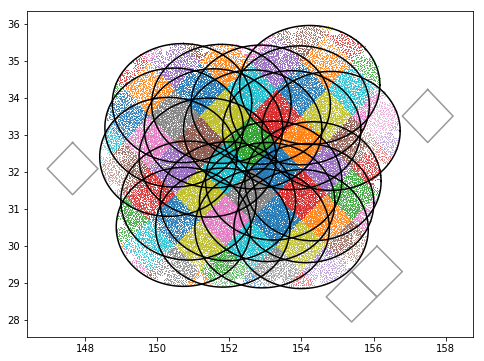

In [62]:
import desispec.io
nside=64
misspix = list()
figure(figsize=(8,6))
for p in pixels:
    specfile = desispec.io.findfile('spectra', nside=nside, groupname=str(p))
    if not os.path.exists(specfile):
        print('Missing {}'.format(os.path.basename(specfile)))
        misspix.append(p)
    else:
        fibermap = Table.read(specfile, 'FIBERMAP')
        plot(fibermap['RA_TARGET'], fibermap['DEC_TARGET'], ',', alpha=0.5)

plot_healpix(nside, misspix)
for t in xtiles:
    plot_tile(t['RA'], t['DEC'])

## Run redrock redshift fitting

TODO: do it, document it

In [64]:
cmd = 'sbatch {}/run/scripts/redshift.slurm'.format(reduxdir)
print(cmd)
# !$cmd

sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/redshift.slurm
Submitted batch job 7169280


# CONTINUE FROM HERE

In [25]:
nodes = 15
cmd = 'srun -N {nodes} -n {nodes} -c 32'.format(nodes=nodes)
cmd += ' {}/wrap-redrock --mpi'.format(os.getcwd())
print(cmd)

srun -N 15 -n 15 -c 32 /global/cscratch1/sd/sjbailey/desi/code/two_percent_DESI/mini/wrap-redrock --mpi


#### Sort bricks by number of targets

In [65]:
import desitarget.io

In [66]:
specdir = os.path.join(os.getenv('DESI_SPECTRO_REDUX'), os.getenv('SPECPROD'), 'spectra-64')
specfiles = list()
for specfile in list(desitarget.io.iter_files(specdir, 'spectra')):
    fm = desispec.io.read_fibermap(specfile)
    ntarg = len(np.unique(fm['TARGETID']))
    nspec = len(fm)
    specfiles.append( (ntarg, nspec, os.path.basename(specfile)) )

specfiles = sorted(specfiles)
specfiles

[(2, 4, 'spectra-64-5314.fits'),
 (3, 6, 'spectra-64-5355.fits'),
 (6, 12, 'spectra-64-5289.fits'),
 (18, 36, 'spectra-64-5281.fits'),
 (20, 20, 'spectra-64-5326.fits'),
 (27, 54, 'spectra-64-5356.fits'),
 (40, 41, 'spectra-64-5294.fits'),
 (44, 90, 'spectra-64-5650.fits'),
 (63, 126, 'spectra-64-5654.fits'),
 (78, 156, 'spectra-64-5283.fits'),
 (98, 151, 'spectra-64-5262.fits'),
 (138, 322, 'spectra-64-5653.fits'),
 (141, 141, 'spectra-64-5266.fits'),
 (147, 149, 'spectra-64-5261.fits'),
 (174, 356, 'spectra-64-5651.fits'),
 (177, 177, 'spectra-64-5321.fits'),
 (177, 426, 'spectra-64-5354.fits'),
 (217, 429, 'spectra-64-5348.fits'),
 (239, 478, 'spectra-64-5350.fits'),
 (287, 399, 'spectra-64-5637.fits'),
 (338, 578, 'spectra-64-5271.fits'),
 (491, 1086, 'spectra-64-5353.fits'),
 (551, 616, 'spectra-64-5267.fits'),
 (602, 1191, 'spectra-64-5292.fits'),
 (645, 976, 'spectra-64-5320.fits'),
 (742, 1067, 'spectra-64-5270.fits'),
 (751, 1303, 'spectra-64-5284.fits'),
 (759, 1039, 'spectra

## Create zcatalog

**TODO**: fix trailing space in TRUESPECTYPE, SPECTYPE

In [19]:
cmd = 'desi_zcatalog -i {reduxdir}/spectra-64 -o {reduxdir}/zcatalog.fits'.format(reduxdir=reduxdir)
print(cmd)

desi_zcatalog -i /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/spectra-64 -o /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/zcatalog.fits


In [28]:
## Redshift QA
truth = Table.read(targetdir+'/truth.fits')
zcat = Table.read(reduxdir+'/zcatalog.fits')

truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

In [29]:
import astropy.table
ztruth = astropy.table.join(zcat, truth, keys='TARGETID')

In [34]:
isELG = (ztruth['TEMPLATETYPE'] == 'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == 'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == 'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == 'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == 'BGS')
print('QSO ', np.count_nonzero(isQSO))
print('LRG ', np.count_nonzero(isLRG))
print('ELG ', np.count_nonzero(isELG))
print('STAR', np.count_nonzero(isSTAR))
print('BGS ', np.count_nonzero(isBGS))

QSO  3198
LRG  4601
ELG  9798
STAR 1054
BGS  4124


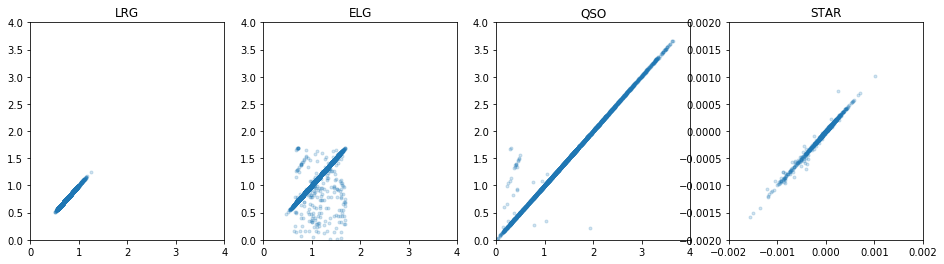

In [35]:
def plotz(ztruth, label, zmin=0.0, zmax=1.5):
    plot(ztruth['TRUEZ'], ztruth['Z'], '.', label=label, alpha=0.2)
    title(label)
    xlim(zmin, zmax); ylim(zmin, zmax)

figure(figsize=(16,4))
subplot(141); plotz(ztruth[isLRG], 'LRG', zmax=4)
subplot(142); plotz(ztruth[isELG], 'ELG', zmax=4)
subplot(143); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(144); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)

In [63]:
def zstats(zx, dvlimit=1000, count=False):
    dv = 1e5 * (zx['Z'] - zx['TRUEZ'])/(1+zx['TRUEZ'])
    good = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] == 0)
    fail = (np.abs(dv)> dvlimit) & (zx['ZWARN'] == 0)
    miss = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] != 0)
    lost = (np.abs(dv)> dvlimit) & (zx['ZWARN'] != 0)
    ngood = np.count_nonzero(good)
    nfail = np.count_nonzero(fail)
    nmiss = np.count_nonzero(miss)
    nlost = np.count_nonzero(lost)
    ntot = len(dv)
    assert(ntot == ngood+nfail+nmiss+nlost)
    if count:
        return ngood, nfail, nmiss, nlost
    elif ntot == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    else:
        return 100*ngood/ntot, 100*nfail/ntot, 100*nmiss/ntot, 100*nlost/ntot

print('        good  fail  miss  lost')
print('        GOOD  FAIL  MISS  LOST')
for objtype in set(ztruth['TEMPLATETYPE']):
    isx = ztruth['TEMPLATETYPE'] == objtype
    pgood, pfail, pmiss, plost = zstats(ztruth[isx])
    print('{:6s} {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, pgood, pfail, pmiss, plost))

        good  fail  miss  lost
        GOOD  FAIL  MISS  LOST
STAR    78.0   0.6   5.0  16.4
WD      86.4  12.1   0.0   1.5
ELG     94.9   0.3   2.7   2.1
QSO     98.1   0.7   0.8   0.3
BGS     99.9   0.0   0.0   0.0
LRG    100.0   0.0   0.0   0.0


In [41]:
g = 22.5 - 2.5*np.log10(ztruth['DECAM_FLUX'][:,1])

In [65]:
magbins = np.linspace(16, 24, 17)
midmag = 0.5*(magbins[0:-1] + magbins[1:])
zeff = list()
for i in range(len(magbins)-1):
    maglo, maghi = magbins[i:i+2]
    ismag = (maglo < g) & (g < maghi)
    pgood, pfail, pmiss, plost = zstats(ztruth[isQSO & ismag])
    nmag = np.count_nonzero(isQSO & ismag)
    print('{:.1f}-{:.1f} {:4d} {:6s} {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(maglo, maghi, nmag, 'QSO', pgood, pfail, pmiss, plost))
    zeff.append(pgood)


16.0-16.5    0 QSO      nan   nan   nan   nan
16.5-17.0    0 QSO      nan   nan   nan   nan
17.0-17.5    4 QSO    100.0   0.0   0.0   0.0
17.5-18.0   13 QSO    100.0   0.0   0.0   0.0
18.0-18.5   31 QSO    100.0   0.0   0.0   0.0
18.5-19.0   74 QSO     98.6   0.0   0.0   1.4
19.0-19.5  136 QSO     98.5   0.7   0.7   0.0
19.5-20.0  193 QSO     99.5   0.0   0.5   0.0
20.0-20.5  330 QSO     98.2   0.6   1.2   0.0
20.5-21.0  386 QSO     99.2   0.3   0.5   0.0
21.0-21.5  532 QSO     99.2   0.8   0.0   0.0
21.5-22.0  524 QSO     97.3   1.5   0.8   0.4
22.0-22.5  598 QSO     98.8   0.5   0.5   0.2
22.5-23.0  352 QSO     96.0   0.9   2.8   0.3
23.0-23.5   25 QSO     68.0   4.0   8.0  20.0
23.5-24.0    0 QSO      nan   nan   nan   nan


In [61]:
magbins

array([16])

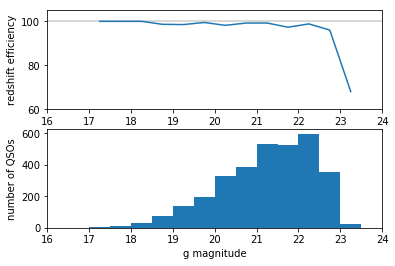

In [77]:
subplot(211)
axhline(100, color='0.8')
plot(midmag, zeff)
xlim(magbins[0], magbins[-1])
ylabel('redshift efficiency')
ylim(60,105)

subplot(212)
hist(g[isQSO], len(magbins)-1, (magbins[0], magbins[-1]))
xlim(magbins[0], magbins[-1])
xlabel('g magnitude')
ylabel('number of QSOs')

In [57]:
np.linspace(16, 24, 17)

array([ 16. ,  16.5,  17. ,  17.5,  18. ,  18.5,  19. ,  19.5,  20. ,
        20.5,  21. ,  21.5,  22. ,  22.5,  23. ,  23.5,  24. ])